In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [34]:
open_shots_df = pd.read_csv('data/clean/open_shot.csv')

In [35]:
# Get percent of open shots for shooters
shooter_summary = open_shots_df.groupby('player_id').agg(
    player_name=('player_name', 'first'),
    fg=('fgm', 'sum'),
    fga=('fgm', 'count'),
    open_shots=('open_shot', 'sum')
).assign(
    fg_pct=lambda x: x['fg'] / x['fga'],
    open_shot_pct=lambda x: x['open_shots'] / x['fga']
).sort_values(by='open_shots', ascending=False)

# Renaming the open_shot_pct column
shooter_summary = shooter_summary.rename(columns={'open_shot_pct': 'pct_shots_open'})

# Display the first few rows of the DataFrame
shooter_summary.head()

,player_name,fg,fga,open_shots,fg_pct,pct_shots_open
player_id,,,,,,
101108,chris paul,425,885,643,0.480226,0.726554
101145,mnta ellis,473,1052,641,0.449620,0.609316
201939,stephen curry,470,968,633,0.485537,0.653926
203081,damian lillard,426,986,587,0.432049,0.595335
202322,john wall,392,874,576,0.448513,0.659039


In [36]:
# Get home and away teams from matchup description
def parse_matchup(matchup):
    _, teams = matchup.split(' - ')
    if '@' in teams:
        away, home = teams.split(' @ ')
    else:
        home, away = teams.split(' vs. ')
    return home, away

# Apply the function to the 'matchup' column
open_shots_df[['home_team_code', 'away_team_code']] = open_shots_df['matchup'].apply(lambda x: pd.Series(parse_matchup(x)))


In [37]:
# Get teams on offense and defense
open_shots_df['off_team_code'] = open_shots_df.apply(
    lambda row: row['away_team_code'] if row['location'] == 'A' else row['home_team_code'], axis=1
)
open_shots_df['def_team_code'] = open_shots_df.apply(
    lambda row: row['home_team_code'] if row['location'] == 'A' else row['away_team_code'], axis=1
)

In [71]:
# Load team ratings
team_ratings_df = pd.read_csv('data/clean/team_ratings.csv')
team_shooting_df = pd.read_csv('data/clean/team_shooting.csv')

In [59]:
# Get percent of open shots for each offense
offense_summary = open_shots_df.groupby('off_team_code').agg(
    fg=('fgm', 'sum'),
    fga=('fgm', 'count'),
    open_shots=('open_shot', 'sum')
).assign(
    fg_pct=lambda x: x['fg'] / x['fga'],
    open_shot_pct=lambda x: x['open_shots'] / x['fga']
).sort_values(by='open_shot_pct', ascending=False)

# Renaming the open_shot_pct column
offense_summary = offense_summary.rename(columns={'open_shot_pct': 'pct_shots_open'})

# Add team offensive ratings
offense_summary = offense_summary.merge(
    team_ratings_df[['Code', 'ORtg']],
    left_on='off_team_code',
    right_on='Code',
    how='left'
)

# Add true shooting percentage
offense_summary = offense_summary.merge(
    team_shooting_df[['Team', 'TS%']],
    left_on='Code',
    right_on='Team',
    how='left'
)

# Drop 'Team' column and rename 'Code' column
offense_summary = offense_summary.drop(columns=['Team'])
offense_summary = offense_summary.rename(columns={'Code': 'team_code'})

# Display the first few rows of the DataFrame
offense_summary.head()

,fg,fga,open_shots,fg_pct,pct_shots_open,team_code,ORtg,TS%
0,2303,4841,2994,0.475728,0.618467,LAC,113.21,0.565
1,1839,4216,2596,0.436195,0.615750,POR,108.81,0.544
2,2100,4547,2690,0.461843,0.591599,DAL,110.30,0.550
3,2182,4553,2651,0.479244,0.582253,GSW,112.18,0.571
4,2128,4544,2640,0.468310,0.580986,ATL,110.00,0.563


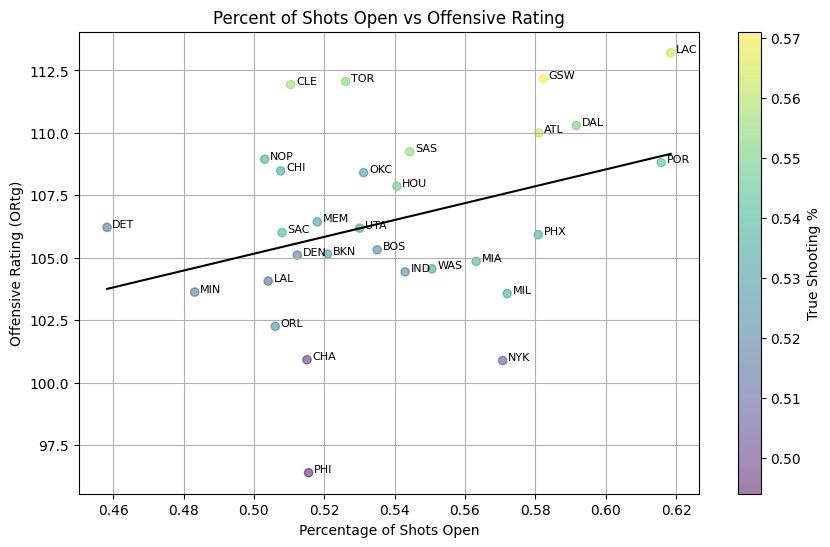

In [75]:
# Extracting x, y, and color values
x = offense_summary['pct_shots_open']
y = offense_summary['ORtg']
colors = offense_summary['TS%']

# Calculate the trendline
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
trendline = intercept + slope * x

# Create the scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(x, y, alpha=0.5, c=colors, cmap='viridis')

# Plot the trendline
plt.plot(x, trendline, 'k-')

# Add team codes as labels with an offset
offset = 0.0015
for i, txt in enumerate(offense_summary['team_code']):
    plt.text(x.iloc[i] + offset, y.iloc[i] + offset, txt, fontsize=8)

# Plot styling
plt.title('Percent of Shots Open vs Offensive Rating')
plt.xlabel('Percentage of Shots Open')
plt.ylabel('Offensive Rating (ORtg)')
plt.colorbar(scatter, label='True Shooting %')
plt.grid(True)
plt.show()

In [74]:
# Get percent of open shots for each defense
defense_summary = open_shots_df.groupby('def_team_code').agg(
    fg=('fgm', 'sum'),
    fga=('fgm', 'count'),
    open_shots=('open_shot', 'sum')
).assign(
    fg_pct=lambda x: x['fg'] / x['fga'],
    open_shot_pct=lambda x: x['open_shots'] / x['fga']
).sort_values(by='open_shot_pct', ascending=True)

# Renaming the open_shot_pct column
defense_summary = defense_summary.rename(columns={'open_shot_pct': 'pct_shots_open'})

# Add team defensive ratings
defense_summary = defense_summary.merge(
    team_ratings_df[['Code', 'DRtg']],
    left_on='def_team_code',
    right_on='Code',
    how='left'
)

# Add opponent true shooting percentage
defense_summary = defense_summary.merge(
    team_shooting_df[['Team', 'Opp_TS%']],
    left_on='Code',
    right_on='Team',
    how='left'
)

# Drop 'Team' column and rename 'Code' column
defense_summary = defense_summary.drop(columns=['Team'])
defense_summary = defense_summary.rename(columns={'Code': 'team_code'})

# Display the first few rows of the DataFrame
defense_summary.head()

,fg,fga,open_shots,fg_pct,pct_shots_open,team_code,DRtg,Opp_TS%
0,1951,4396,2133,0.443813,0.485214,SAS,102.61,0.521
1,2062,4543,2250,0.453885,0.495267,PHX,106.85,0.539
2,1852,4204,2093,0.440533,0.497859,ATL,103.98,0.528
3,1993,4331,2188,0.460171,0.505195,NOP,108.15,0.533
4,2028,4512,2314,0.449468,0.512855,CHI,105.11,0.510


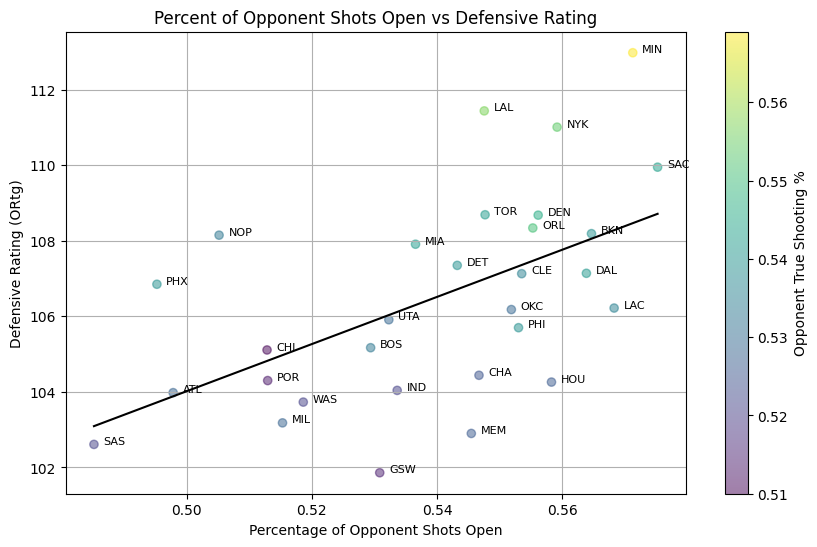

In [76]:
# Extracting x, y, and color values
x = defense_summary['pct_shots_open']
y = defense_summary['DRtg']
colors = defense_summary['Opp_TS%']

# Calculate the trendline
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
trendline = intercept + slope * x

# Create the scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(x, y, alpha=0.5, c=colors, cmap='viridis')

# Plot the trendline
plt.plot(x, trendline, 'k-')

# Add team codes as labels with an offset
offset = 0.0015
for i, txt in enumerate(defense_summary['team_code']):
    plt.text(x.iloc[i] + offset, y.iloc[i] + offset, txt, fontsize=8)

# Plot styling
plt.title('Percent of Opponent Shots Open vs Defensive Rating')
plt.xlabel('Percentage of Opponent Shots Open')
plt.ylabel('Defensive Rating (ORtg)')
plt.colorbar(scatter, label='Opponent True Shooting %')
plt.grid(True)
plt.show()